- **EVENT_ON_MOUSE_MOVE &#8594; 0**
- **EVENT_ON_TOUCH_MOVE &#8594; 7**
- **EVENT_ON_CLICK &#8594; 1**
- **EVENT_ON_DOUBLE_CLICK &#8594; 2**
- **EVENT_ON_MOUSE_DOWN &#8594; 3**
- **EVENT_ON_MOUSE_UP &#8594; 4**
- **EVENT_ON_WHEEL &#8594; 5**
- **EVENT_CONTEXT_MENU &#8594; 6**
- **EVENT_WINDOW_SCROLL &#8594; 11**
- **EVENT_WINDOW_RESIZE &#8594; 12**
- **EVENT_KEY_DOWN &#8594; 13**
- **EVENT_KEY_PRESS &#8594; 14**
- **EVENT_KEY_UP &#8594; 15**
- **EVENT_FOCUS &#8594; 16**
- **EVENT_BLUR &#8594; 17**
- **EVENT_ON_CHANGE_SELECTION_OBJECT &#8594; 18**
- **EVENT_ON_CLICK_SELECTION_OBJECT &#8594; 19**
- **EVENT_INIT_TRACKING &#8594; 100**
- **EVENT_TRACKING_END &#8594; 200**
- **COMPONENT_COMBOBOX &#8594; 2**
- **COMPONENT_OPTION &#8594; 3**

In [1]:
%pip install numpy pandas scikit-learn matplotlib seaborn --quiet

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
random_state = 42

dataset_path1 = 'C:/Users/Usuario/TFM/all_sessions.csv'

df1 = pd.read_csv(dataset_path1,
                  usecols=['sceneId', 'eventType', 'timeStamp', 'x', 'y', 'sessionId'],
                  dtype={
                      'sceneId': 'str',
                      'eventType': 'int',
                      'timeStamp': 'int',
                      'x': 'int',
                      'y': 'int',
                      'sessionId': 'str'
                  })

dataset_path2 = 'data/dataset_small.csv'

df2 = pd.read_csv(dataset_path2,
                  usecols=['sceneId', 'eventType', 'timeStamp', 'x', 'y', 'sessionId'],
                  dtype={
                      'sceneId': 'str',
                      'eventType': 'int',
                      'timeStamp': 'int',
                      'x': 'int',
                      'y': 'int',
                      'sessionId': 'str'
                  })

df = pd.concat([df1, df2], ignore_index=True)

#df.to_csv('data/dataset_all.csv', index=False)


Note: you may need to restart the kernel to use updated packages.


In [2]:
# Count the number of duplicates in the dataset
df.duplicated().sum()
# Remove duplicates
df = df.drop_duplicates()

In [3]:
df.columns

Index(['sceneId', 'eventType', 'timeStamp', 'x', 'y', 'sessionId'], dtype='object')

In [4]:
def calcular_metricas(df):
    df = df.copy()
    df.sort_values(by=['timeStamp'], inplace=True)
    df['timeStamp'] = pd.to_numeric(df['timeStamp'], errors='coerce')

    df['dt'] = df.groupby(['sessionId', 'sceneId'])['timeStamp'].diff().fillna(0)
    df['dx'] = df.groupby(['sessionId', 'sceneId'])['x'].diff().fillna(0)
    df['dy'] = df.groupby(['sessionId', 'sceneId'])['y'].diff().fillna(0)

    df['distance'] = np.sqrt(df['dx'] ** 2 + df['dy'] ** 2)
    df['velocity'] = df['distance'] / df['dt']
    df['acceleration'] = df.groupby(['sessionId', 'sceneId'])['velocity'].diff().fillna(0) / df['dt']

    return df


def filtrar_datos_validos(df):
    df_valid = df[
        (df['x'] > 0) &
        (df['y'] > 0) &
        (df['eventType'] == 7) &
        (df['timeStamp'] > 0)
        ].copy()
    return df_valid.sort_values(['timeStamp'])


def segmentar_trazos(df_valid, time_threshold=200):
    strokes = []
    if len(df_valid) < 2:
        return strokes

    current_stroke = [df_valid.index[0]]

    for i in range(1, len(df_valid)):
        current_idx = df_valid.index[i]
        previous_idx = df_valid.index[i - 1]
        time_diff = abs(df_valid.loc[current_idx, 'y'] - df_valid.loc[previous_idx, 'y'])

        if time_diff <= time_threshold:
            current_stroke.append(current_idx)
        else:
            if len(current_stroke) >= 2:
                strokes.append(current_stroke)
            current_stroke = [current_idx]

    if len(current_stroke) >= 2:
        strokes.append(current_stroke)

    return strokes


def visualizar_trazo(df, stroke_indices, stroke_id):
    stroke_data = df.loc[stroke_indices]
    metrics = calcular_metricas(stroke_data)

    plt.figure(figsize=(10, 8))
    plt.plot(stroke_data['x'], stroke_data['y'], 'b-o', linewidth=2, markersize=4, label='Trazo real')

    x_start, y_start = stroke_data['x'].iloc[0], stroke_data['y'].iloc[0]
    x_end, y_end = stroke_data['x'].iloc[-1], stroke_data['y'].iloc[-1]
    plt.plot([x_start, x_end], [y_start, y_end], 'r--', linewidth=2, label='Línea óptima')

    plt.plot(x_start, y_start, 'go', markersize=8, label='Inicio')
    plt.plot(x_end, y_end, 'ro', markersize=8, label='Fin')

    duration = stroke_data['timeStamp'].iloc[-1] - stroke_data['timeStamp'].iloc[0]
    plt.xlabel('X (píxeles)')
    plt.ylabel('Y (píxeles)')
    plt.title(f'Trazo {stroke_id} - Duración: {duration:.0f}ms - Puntos: {len(stroke_data)}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.gca().invert_yaxis()
    plt.show()

    return metrics


def procesar_trazo(df, stroke_id):
    df_valid = filtrar_datos_validos(df)
    strokes = segmentar_trazos(df_valid)

    if not strokes:
        print("No se encontraron trazos válidos")
        return

    if stroke_id >= len(strokes):
        print(f"No se encontró el trazo {stroke_id}. Trazos disponibles: 0-{len(strokes) - 1}")
        return

    print(f"Total de trazos encontrados: {len(strokes)}")
    for i, stroke in enumerate(strokes):
        stroke_duration = df.loc[stroke[-1], 'timeStamp'] - df.loc[stroke[0], 'timeStamp']
        print(f"Trazo {i}: {len(stroke)} puntos, duración: {stroke_duration:.0f}ms")

    return visualizar_trazo(df, strokes[stroke_id], stroke_id)


def calcular_metricas_trazos(df):
    resultados = []

    # Filtrar datos válidos
    df_valid = df[
        (df['x'] > 0) &
        (df['y'] > 0) &
        (df['eventType'] == 7) &
        (df['timeStamp'] > 0)
        ].copy()

    df_valid = df_valid.sort_values(['sessionId', 'sceneId', 'timeStamp'])

    # Agrupar por sessionId y sceneId
    for (session, scene), grupo in df_valid.groupby(['sessionId', 'sceneId']):
        grupo = grupo.reset_index(drop=True)
        strokes = []
        current_stroke = [0]
        time_threshold = 200

        for i in range(1, len(grupo)):
            time_diff = abs(grupo.loc[i, 'timeStamp'] - grupo.loc[i - 1, 'timeStamp'])
            if time_diff <= time_threshold:
                current_stroke.append(i)
            else:
                if len(current_stroke) >= 2:
                    strokes.append(current_stroke)
                current_stroke = [i]

        if len(current_stroke) >= 2:
            strokes.append(current_stroke)

        for stroke_id, indices in enumerate(strokes):
            trazo = grupo.loc[indices].copy()
            trazo['dt'] = trazo['timeStamp'].diff().replace(0, np.nan)
            trazo['dx'] = trazo['x'].diff()
            trazo['dy'] = trazo['y'].diff()
            trazo['distance'] = np.sqrt(trazo['dx'] ** 2 + trazo['dy'] ** 2)
            trazo['velocity'] = trazo['distance'] / trazo['dt']
            trazo['acceleration'] = trazo['velocity'].diff() / trazo['dt']

            trazo = trazo.replace([np.inf, -np.inf], np.nan).dropna()

            if len(trazo) < 2:
                continue

            duration = trazo['timeStamp'].iloc[-1] - trazo['timeStamp'].iloc[0]
            total_distance = trazo['distance'].sum()
            avg_velocity = trazo['velocity'].mean()
            max_velocity = trazo['velocity'].max()
            min_velocity = trazo['velocity'].min()
            std_velocity = trazo['velocity'].std()
            avg_acceleration = trazo['acceleration'].mean()
            max_acceleration = trazo['acceleration'].max()
            min_acceleration = trazo['acceleration'].min()
            std_acceleration = trazo['acceleration'].std()

            # Área bajo la curva real
            area_real = np.trapezoid(trazo['y'], trazo['x'])

            # Área bajo la línea óptima
            x0, y0 = trazo['x'].iloc[0], trazo['y'].iloc[0]
            x1, y1 = trazo['x'].iloc[-1], trazo['y'].iloc[-1]
            x_opt = np.linspace(x0, x1, len(trazo))
            y_opt = np.linspace(y0, y1, len(trazo))
            area_optima = np.trapezoid(y_opt, x_opt)

            area_diff_ratio = abs(area_real - area_optima) / (abs(area_optima) + 1e-6)

            resultados.append({
                'sessionId': session,
                'sceneId': scene,
                'stroke_id': stroke_id,
                'duration_ms': duration,
                'total_distance': total_distance,
                'avg_velocity': avg_velocity,
                'max_velocity': max_velocity,
                'min_velocity': min_velocity,
                'std_velocity': std_velocity,
                'avg_acceleration': avg_acceleration,
                'max_acceleration': max_acceleration,
                'min_acceleration': min_acceleration,
                'std_acceleration': std_acceleration,
                'num_points': len(trazo),
                'area_real': area_real,
                'area_optima': area_optima,
                'area_diff_ratio': area_diff_ratio
            })

    return pd.DataFrame(resultados)

In [5]:
metricas_trazos = calcular_metricas_trazos(df)

In [6]:
def calcular_metricas_globales_por_sesion_escena(df_metricas_trazos):
    """
    Calcula métricas globales agregadas para cada combinación de sessionId y sceneId.

    Parámetros:
    - df_metricas_trazos: DataFrame con métricas por trazo, incluyendo columnas como:
        ['sessionId', 'sceneId', 'duration_ms', 'total_distance', 'avg_velocity', 'max_velocity',
         'avg_acceleration', 'max_acceleration', 'area_real', 'area_optima', 'area_diff_ratio']

    Retorna:
    - DataFrame con métricas globales agregadas por (sessionId, sceneId)
    """
    # Definir las métricas a agregar y sus funciones de agregación
    metricas = {
        'duration_ms': ['mean', 'max', 'min', 'std'],
        'total_distance': ['mean', 'max', 'min', 'std'],
        'avg_velocity': ['mean', 'max', 'min', 'std'],
        'max_velocity': ['mean', 'max', 'min', 'std'],
        'avg_acceleration': ['mean', 'max', 'min', 'std'],
        'max_acceleration': ['mean', 'max', 'min', 'std'],
        'area_real': ['mean', 'max', 'min', 'std'],
        'area_optima': ['mean', 'max', 'min', 'std'],
        'area_diff_ratio': ['mean', 'max', 'min', 'std'],
        'num_points': ['sum', 'mean']
    }

    # Agrupar por sessionId y sceneId y aplicar agregaciones
    df_global = df_metricas_trazos.groupby(['sessionId', 'sceneId']).agg(metricas)

    # Aplanar columnas jerárquicas
    df_global.columns = ['_'.join(col).strip() for col in df_global.columns.values]
    df_global = df_global.reset_index()

    return df_global

In [9]:
df_global = calcular_metricas_globales_por_sesion_escena(metricas_trazos)

In [10]:
#df_global.to_csv('data/dataset_all_global.csv', index=False)

Total de trazos encontrados: 1
Trazo 0: 101 puntos, duración: 249319ms


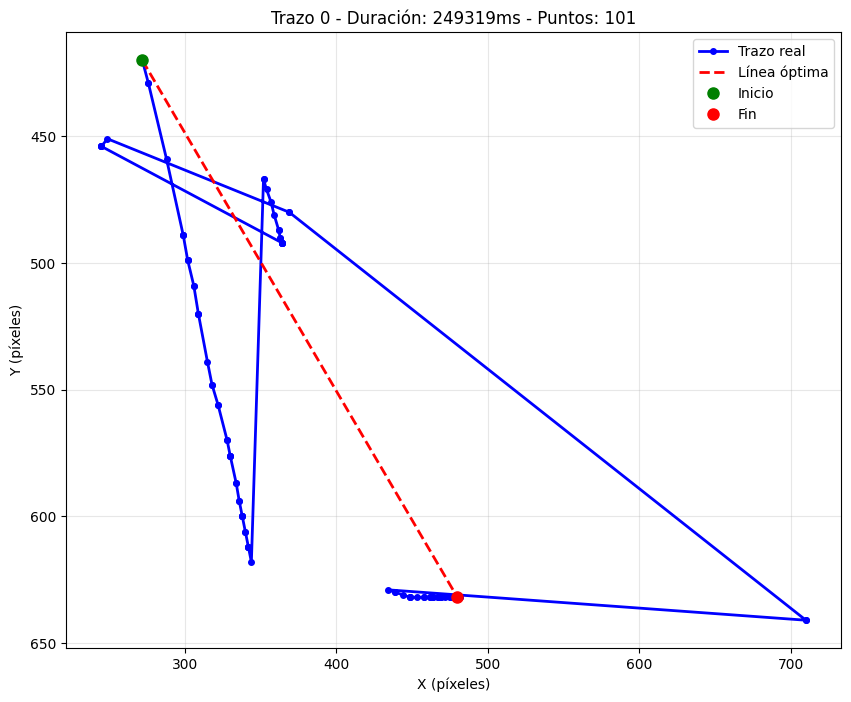

,sceneId,eventType,timeStamp,x,y,sessionId,dt,dx,dy,distance,velocity,acceleration
92538,LA MANO_SYMBOLIC_I-I.phase1,7,1749025308268,272,420,AAZ8612490310781749024507588642025,0.0,0.0,0.0,0.000000,NaN,NaN
92541,LA MANO_SYMBOLIC_I-I.phase1,7,1749025308269,272,420,AAZ8612490310781749024507588642025,1.0,0.0,0.0,0.000000,0.000000,0.000000
92568,LA MANO_SYMBOLIC_I-I.phase1,7,1749025308270,272,420,AAZ8612490310781749024507588642025,1.0,0.0,0.0,0.000000,0.000000,0.000000
92630,LA MANO_SYMBOLIC_I-I.phase1,7,1749025308281,276,429,AAZ8612490310781749024507588642025,11.0,4.0,9.0,9.848858,0.895351,0.081396
92660,LA MANO_SYMBOLIC_I-I.phase1,7,1749025308282,276,429,AAZ8612490310781749024507588642025,1.0,0.0,0.0,0.000000,0.000000,-0.895351
...,...,...,...,...,...,...,...,...,...,...,...,...
145936,LA MANO_SYMBOLIC_I-I.phase1,7,1749025557533,482,632,AAZ8612490310781749024507588642025,11.0,1.0,0.0,1.000000,0.090909,0.008264
145995,LA MANO_SYMBOLIC_I-I.phase1,7,1749025557534,482,632,AAZ8612490310781749024507588642025,1.0,0.0,0.0,0.000000,0.000000,-0.090909
146072,LA MANO_SYMBOLIC_I-I.phase1,7,1749025557579,481,632,AAZ8612490310781749024507588642025,45.0,-1.0,0.0,1.000000,0.022222,0.000494
146143,LA MANO_SYMBOLIC_I-I.phase1,7,1749025557586,480,632,AAZ8612490310781749024507588642025,7.0,-1.0,0.0,1.000000,0.142857,0.017234


In [16]:
procesar_trazo(df[(df['sceneId']=='LA MANO_SYMBOLIC_I-I.phase1') & (df['sessionId']=='AAZ8612490310781749024507588642025')], 0)